In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# data

In [1]:
#Data Preprocessing:
import numpy as np
import os
import cv2
from PIL import Image

image_directory = "/kaggle/input/breast-cancer-dataset/Dataset_BUSI_with_GT/"

def load_images(image_folder, label_value):
    images = [img for img in os.listdir(image_directory + image_folder)]
    for image_name in images:
        if image_name.split('.')[1] == 'png' and '_mask' not in image_name:
            image = cv2.imread(image_directory + image_folder + image_name)
            if image is not None:
                image = Image.fromarray(image, 'RGB')
                image = image.resize((SIZE, SIZE))
                image = np.array(image)
                dataset.append(image)
                label.append(label_value)

SIZE = 128
dataset = []
label = []

load_images('benign/', 0)  # Benign class with label 0
load_images('malignant/', 1)  # Malignant class with label 1
load_images('normal/', 2)  # Normal class with label 2

# Convert dataset and label to numpy arrays
dataset = np.array(dataset)
label = np.array(label)
print("Dataset shape:", dataset.shape)
print("Label shape:", label.shape)

Dataset shape: (780, 128, 128, 3)
Label shape: (780,)


In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Convert dataset and label to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

num_samples, height, width, channels = dataset.shape
X_flat = dataset.reshape(num_samples, -1)  # Reshape to (samples, height*width*channels)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, label, test_size=0.10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10)
X_train = X_train.reshape(-1, 128, 128, 3)  # Reshape your input data to match the expected input shape
X_test= X_test.reshape(-1, 128, 128, 3)  # Reshape your input data to match the expected input shape

2024-03-16 15:50:46.749824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 15:50:46.749963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 15:50:46.888364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Convert X_train to float32 and reshape it for augmentation
X_train = X_train.astype('float32')
X_train = X_train.reshape(-1, 128, 128, 3)
# Initialize ImageDataGenerators for different classes

augmentation_class0 = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=True,
    vertical_flip=False
)
augmentation_class1 = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
augmentation_class2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
#  y_train contains labels where 0, 1, 2 represent classes 0, 1, 2 respectively
indices_class0 = np.where(y_train == 0)[0]  # Indices for class 0
indices_class1 = np.where(y_train == 1)[0]  # Indices for class 1
indices_class2 = np.where(y_train == 2)[0]  # Indices for class 2

X_class0 = X_train[indices_class0]  # Data corresponding to class 1
X_class1 = X_train[indices_class1]  # Data corresponding to class 1
X_class2 = X_train[indices_class2]  # Data corresponding to class 2

# Fit the ImageDataGenerators to respective classes
augmentation_class0.fit(X_class0)
augmentation_class1.fit(X_class1)
augmentation_class2.fit(X_class2)

# Generate augmented images for different classes
augmented_images_class0 = []
augmented_images_class1 = []
augmented_images_class2 = []
for x_batch in augmentation_class0.flow(X_class0, batch_size=len(X_class1), shuffle=False):
    augmented_images_class0.append(x_batch)
    if len(augmented_images_class0) >= 1.4:
        break
        
for x_batch in augmentation_class1.flow(X_class1, batch_size=len(X_class1), shuffle=False):
    augmented_images_class1.append(x_batch)
    if len(augmented_images_class1) >= 1.5:
        break

for x_batch in augmentation_class2.flow(X_class2, batch_size=len(X_class2), shuffle=False):
    augmented_images_class2.append(x_batch)
    if len(augmented_images_class2) >=3.0:
        break

#2.5,3 : best
# Concatenate augmented data for different classes
X_augmented_class0 = np.concatenate(augmented_images_class0)
X_augmented_class1 = np.concatenate(augmented_images_class1)
X_augmented_class2 = np.concatenate(augmented_images_class2)

# Assuming the labels for augmented data
y_augmented_class0 = np.full(len(X_augmented_class0), 0)  # Label for class 2
y_augmented_class1 = np.full(len(X_augmented_class1), 1)  # Label for class 1
y_augmented_class2 = np.full(len(X_augmented_class2), 2)  # Label for class 2

# Concatenate augmented data and labels with the original data and labels
X_train_augmented = np.concatenate([X_train,X_augmented_class1, X_augmented_class2])
y_train_augmented = np.concatenate([y_train, y_augmented_class1, y_augmented_class2])

# Shuffle the augmented dataset
shuffle_indices = np.random.permutation(len(y_train_augmented))
X_train = X_train_augmented[shuffle_indices]
y_train = y_train_augmented[shuffle_indices]


# Verify the shape of the augmented dataset
print("Shape of augmented images:", X_train.shape)
# Calculate the number of samples in each class after augmentation
print("Number of samples in benign :", len(X_augmented_class0))
print("Number of samples in malignant after augmentation:", len(X_augmented_class1))
print("Number of samples in normal after augmentation:", len(X_augmented_class2))

from sklearn.utils.class_weight import compute_class_weight
# Compute class weights
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weight = {i: weight for i, weight in enumerate(class_weights)}









Shape of augmented images: (1281, 128, 128, 3)
Number of samples in benign : 350
Number of samples in malignant after augmentation: 350
Number of samples in normal after augmentation: 300


In [4]:

import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

# efficientnet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = EfficientNetB0(weights='imagenet', include_top=False,
                            input_shape=(128, 128, 3))

# Add custom top layers for your 3-class classification with regularization and dropout
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Freeze layers from the pre-trained model
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True
    
    
# Compile the model with a lower learning rate and different optimizer
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path with correct file extension
checkpoint_path = '/kaggle/working/best_model_weights.weights.h5'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)

# Train the model with data augmentation and the modified architecture
history = model.fit(X_train,y_train, class_weight=class_weight, epochs=20, 
                    validation_split=.2, callbacks=[checkpoint], verbose = 1) 
                    
                    
model.load_weights(checkpoint_path)

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras


In [ ]:
model.summary()

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(loss)
print(acc)

In [ ]:
y_pred=model.predict(X_test)
print(y_pred)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()


# InceptionResNetV2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


base_model1 = tf.keras.applications.InceptionResNetV2(
                include_top=False,
                weights="imagenet",
                input_shape=(128, 128, 3)
            )
# Add custom top layers for your 3-class classification with regularization and dropout
model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dropout(0.5))
model1.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dropout(0.3))
model1.add(Dense(3, activation='softmax'))

# Freeze layers from the pre-trained model
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True
    
    
# Compile the model with a lower learning rate and different optimizer
model1.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path with correct file extension
checkpoint_path = '/kaggle/working/best_model2_weights.weights.h5'
# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)

# Train the model with data augmentation and the modified architecture
history = model1.fit(X_train,y_train, class_weight=class_weight, epochs=20, 
                    validation_split=.2, callbacks=[checkpoint], verbose = 1) 
                    
                    
model1.load_weights(checkpoint_path)

In [ ]:
loss, acc = model1.evaluate(X_test, y_test)
print(loss)
print(acc)

In [ ]:
y_pred1=model1.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
y_pred_labels1 = np.argmax(y_pred1, axis=1)
# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels1)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()


# resnet

In [ ]:

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.layers import Flatten
# Load ResNet50 as base model
base_model12 = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your 3-class classification with regularization and dropout
model12 = Sequential()
model12.add(base_model12)
model12.add(Flatten())
model12.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model12.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model12.add(Dense(3, activation='softmax'))


# Compile the model
#model12.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model12.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model12.fit(X_train,y_train, class_weight=class_weight, epochs=20, 
                    validation_split=.2, callbacks=[checkpoint], verbose = 1) 

In [ ]:
loss, acc = model12.evaluate(X_test, y_test)
print(loss)
print(acc)
y_pred2=model12.predict(X_test)
y_pred_labels2 = np.argmax(y_pred2, axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels2)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

# mobilenet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet

base_model3 =MobileNet (weights='imagenet', include_top=False,
                            input_shape=(128, 128, 3))

# Add custom top layers for your 3-class classification with regularization and dropout
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(Dropout(0.3))
model3.add(Dense(3, activation='softmax'))

# Freeze layers from the pre-trained model
for layer in base_model3.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True
    
    
# Compile the model with a lower learning rate and different optimizer
model3.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path with correct file extension
checkpoint_path = '/kaggle/working/best_model_weights.weights.h5'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)

# Train the model with data augmentation and the modified architecture
history = model3.fit(X_train,y_train, class_weight=class_weight, epochs=20, 
                    validation_split=.2, callbacks=[checkpoint], verbose = 1) 
                    
                    
model3.load_weights(checkpoint_path)

In [ ]:
loss, acc = model3.evaluate(X_test, y_test)
print(loss)
print(acc)

y_pred3=model3.predict(X_test)
y_pred_labels3 = np.argmax(y_pred3, axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels3)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

# vgg16

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam



base_model4 =VGG16(weights='imagenet', include_top=False,
                            input_shape=(128,128, 3))


# Freeze the layers of the base model
for layer in base_model4.layers:
    layer.trainable = False

# Add custom top layers for your 3-class classification with regularization and dropout
model4 = Sequential()
model4.add(base_model4)
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(3, activation='softmax'))


# Compile the model
#model12.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model4.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model4.fit(X_train,y_train, class_weight=class_weight, epochs=20, 
                   validation_split=.2 , verbose = 1) 



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


2024-03-16 15:51:39.667444: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.34782, expected 3.51669
2024-03-16 15:51:39.667505: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.71977, expected 5.88864
2024-03-16 15:51:39.667515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.95696, expected 6.12583
2024-03-16 15:51:39.667523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48105, expected 5.64992
2024-03-16 15:51:39.667531: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.32797, expected 4.49684
2024-03-16 15:51:39.667538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.7497, expected 4.91857
2024-03-16 15:51:39.667546: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.01592, expected 5.18479
2024-03-16 15:51:39.667554: E external/local_xla/xla/ser

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3762 - loss: 20.7227

I0000 00:00:1710604306.646003     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5168 - loss: 11.7011

2024-03-16 15:51:48.678058: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 3.66788, expected 2.82077
2024-03-16 15:51:48.678112: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32769: 5.27059, expected 4.42348
2024-03-16 15:51:48.678122: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32770: 5.00058, expected 4.15347
2024-03-16 15:51:48.678131: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32771: 4.72297, expected 3.87586
2024-03-16 15:51:48.678139: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32772: 4.5861, expected 3.73899
2024-03-16 15:51:48.678147: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32773: 4.17555, expected 3.32844
2024-03-16 15:51:48.678155: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32774: 3.43326, expected 2.58615
2024-03-16 15:51:48.678164: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.5283 - loss: 11.1485 - val_accuracy: 0.7160 - val_loss: 1.3683
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8693 - loss: 0.4869 - val_accuracy: 0.7899 - val_loss: 10562.5166
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9647 - loss: 0.1136 - val_accuracy: 0.8521 - val_loss: 0.5433
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9863 - loss: 0.0406 - val_accuracy: 0.8444 - val_loss: 2856.2295
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9962 - loss: 0.0165 - val_accuracy: 0.8444 - val_loss: 0.6654
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9939 - loss: 0.0474 - val_accuracy: 0.8560 - val_loss: 0.7797
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9941 - loss: 0.0349 - val_accuracy: 0.8288 - val_loss: 0.8894
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9866 - loss: 0.0689 - val_accuracy: 0.8366 - va

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step - accuracy: 0.8125 - loss: 1.4299

2024-03-16 15:52:14.740074: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.35343, expected 3.47357
2024-03-16 15:52:14.740137: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.99384, expected 5.11397
2024-03-16 15:52:14.740146: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.60323, expected 5.72337
2024-03-16 15:52:14.740154: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.4805, expected 5.60063
2024-03-16 15:52:14.740162: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37986, expected 4.5
2024-03-16 15:52:14.740170: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.45361, expected 4.57374
2024-03-16 15:52:14.740178: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.86515, expected 3.98529
2024-03-16 15:52:14.740186: E external/local_xla/xla/service

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8101 - loss: 2.5522  
3.380535125732422
0.807692289352417
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


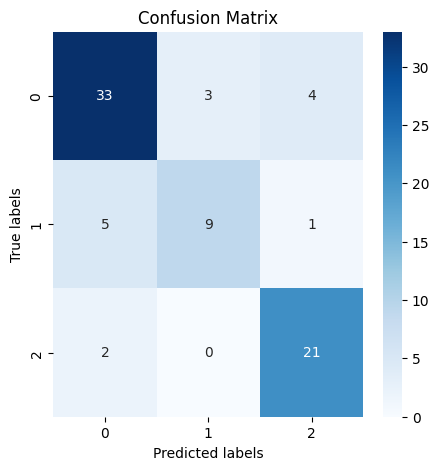

In [6]:
loss, acc = model4.evaluate(X_test, y_test)
print(loss)
print(acc)
y_pred4=model4.predict(X_test)
y_pred_labels4 = np.argmax(y_pred4, axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels4)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

# deepcnn

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def DeepCNN(input_shape, num_classes):
    model = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Define input shape and number of classes
input_shape = (128,128,3)  # Example input shape for RGB images
num_classes = 3  # Define the number of classes in your dataset

# Create a deep CNN model
model = DeepCNN(input_shape, num_classes)

    
    
# Compile the model with a lower learning rate and different optimizer
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path with correct file extension
checkpoint_path = '/kaggle/working/best_model_weights.weights.h5'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)

# Train the model with data augmentation and the modified architecture
history = model.fit(X_train,y_train, class_weight=class_weight, epochs=20, 
                    validation_split=.2, callbacks=[checkpoint], verbose = 1) 
              
                    
model.load_weights(checkpoint_path)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20


2024-03-16 15:52:26.966098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31758: 7.18885, expected 6.34915
2024-03-16 15:52:26.966149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31794: 6.79032, expected 5.95062
2024-03-16 15:52:26.966159: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31795: 6.91364, expected 6.07395
2024-03-16 15:52:26.966167: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31796: 7.21123, expected 6.37153
2024-03-16 15:52:26.966181: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31809: 7.14567, expected 6.30597
2024-03-16 15:52:26.966189: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31823: 7.30269, expected 6.46299
2024-03-16 15:52:26.966196: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31824: 7.17199, expected 6.33229
2024-03-16 15:52:26.966204:

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3635 - loss: 148.7950

2024-03-16 15:52:35.955416: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4610: 3.93875, expected 3.42964
2024-03-16 15:52:35.955535: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14521: 3.93875, expected 3.42964
2024-03-16 15:52:35.955552: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15882: 6.56496, expected 5.80551
2024-03-16 15:52:35.955560: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15918: 5.95458, expected 5.19513
2024-03-16 15:52:35.955568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15919: 6.47927, expected 5.71982
2024-03-16 15:52:35.955576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15927: 6.48245, expected 5.723
2024-03-16 15:52:35.955584: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15928: 6.2255, expected 5.46605
2024-03-16 15:52:35.955594: E e


Epoch 1: val_accuracy improved from -inf to 0.56031, saving model to /kaggle/working/best_model_weights.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.3654 - loss: 142.9628 - val_accuracy: 0.5603 - val_loss: 64390.6328
Epoch 2/20
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5668 - loss: 0.9399
Epoch 2: val_accuracy did not improve from 0.56031
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5650 - loss: 0.9417 - val_accuracy: 0.4825 - val_loss: 75965.9922
Epoch 3/20
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5075 - loss: 0.9715
Epoch 3: val_accuracy did not improve from 0.56031
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5082 - loss: 0.9722 - val_accuracy: 0.4669 - val_loss: 83231.5703
Epoch 4/20
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5637 - loss: 0.9235
Epoch 4: val_accuracy did not improve from 0.56031
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5642 - loss: 0.9228 - val_accuracy: 0.4825 - val_loss: 849

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - accuracy: 0.6875 - loss: 2.0698

2024-03-16 15:53:12.245554: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16053: 5.59949, expected 4.92021
2024-03-16 15:53:12.245614: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16054: 5.29957, expected 4.62029
2024-03-16 15:53:12.245630: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16062: 5.49836, expected 4.81908
2024-03-16 15:53:12.245644: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16063: 5.71858, expected 5.03929
2024-03-16 15:53:12.245656: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16218: 5.67184, expected 4.99255
2024-03-16 15:53:12.245667: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16309: 5.69257, expected 5.01329
2024-03-16 15:53:12.245685: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16426: 5.16342, expected 4.48413
2024-03-16 15:53:12.245695:

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 786ms/step - accuracy: 0.5767 - loss: 108.4026
214.56146240234375
0.5128205418586731
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


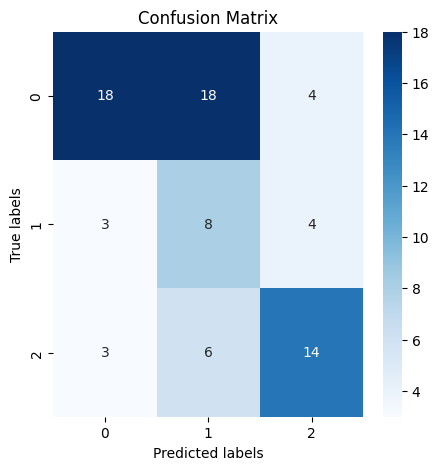

In [8]:
loss, acc = model.evaluate(X_test, y_test)
print(loss)
print(acc)
y_pred15=model.predict(X_test)
y_pred_labels15 = np.argmax(y_pred15, axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels15)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

# alexnet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def AlexNet(input_shape, num_classes):
    # Define input layer
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (128,128, 3)  # AlexNet takes 227x227 images
num_classes = 3  # Define the number of classes in your dataset

# Create AlexNet model
model7 = AlexNet(input_shape, num_classes)


    
    
# Compile the model with a lower learning rate and different optimizer
model7.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path with correct file extension
checkpoint_path = '/kaggle/working/best_model_weights.weights.h5'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)

# Train the model with data augmentation and the modified architecture
history = model7.fit(X_train,y_train, class_weight=class_weight, epochs=20, 
                    validation_split=.2, callbacks=[checkpoint], verbose = 1) 
                    
                    
model7.load_weights(checkpoint_path)

In [ ]:
loss, acc = model7.evaluate(X_test, y_test)
print(loss)
print(acc)
y_pred7=model7.predict(X_test)
y_pred_labels7 = np.argmax(y_pred7, axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels7)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

# vgg19

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG19

base_model41 =VGG19(weights='imagenet', include_top=False,
                            input_shape=(128,128, 3))


# Freeze the layers of the base model
for layer in base_model41.layers:
    layer.trainable = False

# Add custom top layers for your 3-class classification with regularization and dropout
model41 = Sequential()
model41.add(base_model41)
model41.add(Flatten())
model41.add(Dense(256, activation='relu'))
model41.add(Dense(128, activation='relu'))
model41.add(Dense(3, activation='softmax'))


# Compile the model
#model12.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model41.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model41.fit(X_train,y_train, class_weight=class_weight, epochs=20, 
                    validation_split=.2, verbose = 1) 



In [ ]:
loss, acc = model41.evaluate(X_test, y_test)
print(loss)
print(acc)
y_pred41=model41.predict(X_test)
y_pred_labels41 = np.argmax(y_pred41, axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels41)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

# polynet

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def ConvUnit(inputs, num_filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = Conv2D(num_filters, kernel_size, activation=activation, padding=padding)(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

def PolyNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Convolutional units with different kernel sizes
    conv1 = ConvUnit(inputs, 32, kernel_size=(3, 3))
    conv2 = ConvUnit(inputs, 32, kernel_size=(5, 5))
    conv3 = ConvUnit(inputs, 32, kernel_size=(7, 7))
    
    # Concatenate feature maps from different convolutional units
    x = concatenate([conv1, conv2, conv3], axis=-1)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model



# Define input shape and number of classes
input_shape = (128,128, 3)  # AlexNet takes 227x227 images
num_classes = 3  # Define the number of classes in your dataset



model11= PolyNet(input_shape, num_classes)
    
    
# Compile the model with a lower learning rate and different optimizer
model11.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path with correct file extension
checkpoint_path = '/kaggle/working/best_model_weights.weights.h5'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)

# Train the model with data augmentation and the modified architecture
history = model11.fit(X_train,y_train, class_weight=class_weight, epochs=20, 
                    validation_split=.2, callbacks=[checkpoint], verbose = 1) 
                    
                    
model11.load_weights(checkpoint_path)


In [ ]:
loss, acc = model11.evaluate(X_test, y_test)
print(loss)
print(acc)
y_pred22=model11.predict(X_test)
y_pred_labels22= np.argmax(y_pred22, axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels22)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()